In [116]:
from thinkbayes2 import Suite, thinkplot, Pmf

# Chapter 4 - More Estimation
## 4.1 The Euro Problem

In [2]:
class Euro(Suite):
    
    def Likelihood(self, data, hypo):
        x = hypo
        if data == 'H':
            return x / 100
        else:
            return 1 - (x / 100)

In [3]:
suite = Euro(range(0, 101))

In [4]:
dataset = 'H' * 140 + 'T'*110

In [5]:
for data in dataset:
    suite.Update(data)

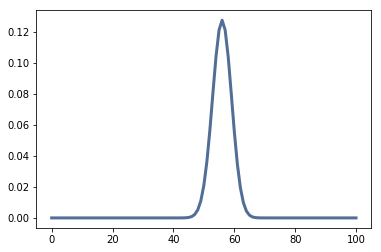

In [6]:
thinkplot.plot(suite)

## 4.2 Summarizing the prior

In [7]:
print(f'Mean : {suite.Mean()}')
print(f'MLE : {suite.MaximumLikelihood()}')
print(f'Median : {suite.Percentile(0.5)}')
print(f'CI: {suite.CredibleInterval(90)}')
print(f'Probability of 50%: {suite.Prob(50)}')

Mean : 55.952380952380956
MLE : 56
Median : 48
CI: (51, 61)
Probability of 50%: 0.02097652612954468


## 4.3 Swamping the prior

In [8]:
def TrianglePrior():
    suite = Euro()
    for x in range(0, 51):
        suite.Set(x, x)
    for x in range(51, 101):
        suite.Set(x, 100 - x)
    suite.Normalize()

In [9]:
TrianglePrior()

In [10]:
for data in dataset:
    suite.Update(data)

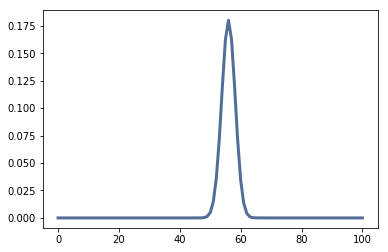

In [11]:
thinkplot.plot(suite)

## 4.4 Optimizing

In [12]:
heads = 140
tails = 110
dataset = 'H' * heads + 'T' * tails

In [13]:
suite.UpdateSet(dataset)

2.7433917001574044e-75

In [14]:
suite = Euro(range(0, 101))
suite.UpdateSet(dataset)

2.6088321798736822e-76

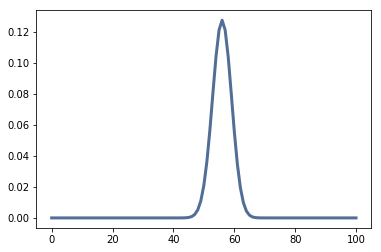

In [15]:
thinkplot.Plot(suite)

In [16]:
class Euro(Suite):
    
    def Likelihood(self, data, hypo):
        x = hypo / 100.0
        heads, tails = data
        like = x**heads * (1-x)**tails
        return like

In [17]:
suite = Euro(range(0, 101))

In [18]:
heads, tails = 140, 110
suite.Update((heads, tails))

2.6088321798736822e-76

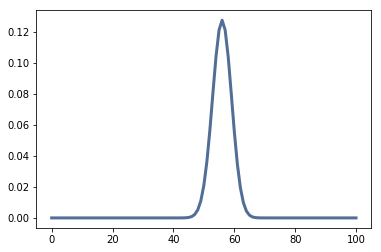

In [19]:
thinkplot.Plot(suite)

## 4.5 The beta distribution

In [20]:
from thinkbayes2 import Beta
beta = Beta()
beta.Update((140, 110))

In [21]:
print(beta.Mean())

0.5595238095238095


## 4.7 Exercises

### Exercise 1

> One way to construct priors is to make a Beta distribution and adjust the parameters until it has the shape you want. Then when you do an update, the data get added to the parameters of the prior. Since the parameters of the prior play the same mathematical role as the data, they are sometimes called "precounts".
> 
> Suppose you believe that most coins are fair or unlikely to deviate from 50% by more than a few percentage points. Construct a prior that captures this belief and update it with the Euro data. How much effect does it have on the posterior, compared to the uniform prior?
> 
> Hint: A Beta distribution with parameters (1, 1) is uniform from 0 to 1.

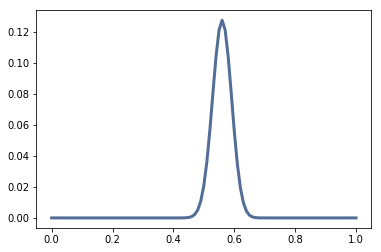

In [66]:
# Uniform prior
uniform = Beta(1,1,label='uniform')
uniform.Update((140,110))
thinkplot.Pdf(uniform.MakePmf())

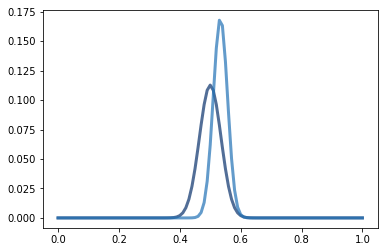

In [67]:
# Centered at 50/50
beta = Beta(100,100,label='beta')
thinkplot.Pdf(beta.MakePmf())
beta.Update((140,110))
thinkplot.Pdf(beta.MakePmf())

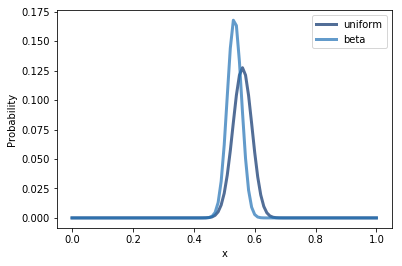

In [69]:
thinkplot.Pdf(uniform.MakePmf())
thinkplot.Pdf(beta.MakePmf())
thinkplot.Config(xlabel='x', ylabel='Probability')

In [78]:
print(uniform.Percentile(2.5),uniform.Percentile(97.5))
print(beta.Percentile(2.5),beta.Percentile(97.5))

0.497956218644013 0.6201963274235325
0.487171899803707 0.5792140943142239


### Exercise 3
> At the 2016 Summer Olympics in the Women's Skeet event, Kim Rhode faced Wei Meng in the bronze medal match. They each hit 15 of 25 skeets, sending the match into sudden death. In the first round, both hit 1 of 2 skeets. In the next two rounds, they each hit 2 skeets. Finally, in the fourth round, Rhode hit 2 and Wei hit 1, so Rhode won the bronze medal, making her the first Summer Olympian to win an individual medal at six consecutive summer games.
> 
> But after all that shooting, what is the probability that Rhode is actually a better shooter than Wei? If the same match were held again, what is the probability that Rhode would win?
> 
> As always, you will have to make some modeling decisions, but one approach is to estimate, for each shooter, the probability of hitting a skeet. Then, to estimate the probability that Rhode is a better shooter, you can draw samples from the two posterior distributions and compare them. To estimate the probability of winning a rematch, you could draw samples from the posterior distributions and simulate a round of 25 shots.

0.6009

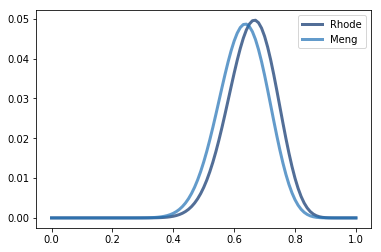

In [112]:
import numpy as np

# Estimate the probability of hitting a skeet
## Maybe we can make x the number of skeets
## data is hits, misses

# 25 total skeets in initial round
# 2 total in first round of sudden death
# 2 total in second round of sudden death
# 2 total in third round of sudden death
# 2 total in fourth round of sudden death

rhode = Beta(1,1,label='Rhode')
rhode.Update((22, 11))

meng = Beta(1,1,label='Meng')
meng.Update((21,12))

thinkplot.Pdf(rhode.MakePmf())
thinkplot.Pdf(meng.MakePmf())
thinkplot.Config(x='skeets',y='probability')

# Estimate the probability that Rhode is a better shooter
## Draw from samples from the two posterior distributinos and compare them

rhode_sample = rhode.MakeCdf(10001).Sample(10000)
meng_sample = meng.MakeCdf(10001).Sample(10000)

np.mean(rhode_sample > meng_sample)

# The probability of winning a rematch
## Simulate a round of 25 shots

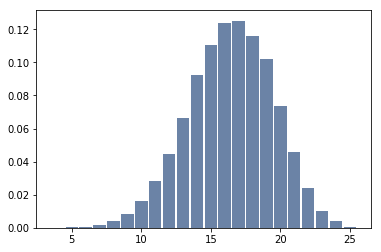

In [156]:
rhode_rematch = np.random.binomial(25, rhode_sample)
thinkplot.Hist(Pmf(rhode_rematch))

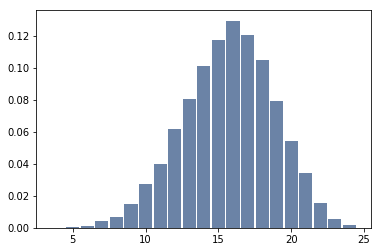

In [157]:
meng_rematch = np.random.binomial(25, meng_sample)
thinkplot.Hist(Pmf(meng_rematch))

In [159]:
# Rhode wins
print(np.mean(rhode_rematch > meng_rematch))

# Meng wings
print(np.mean(rhode_rematch < meng_rematch))

# Ties
print(np.mean(rhode_rematch == meng_rematch))

0.5162
0.3991
0.0847


### Exercise 4
> Suppose that instead of observing coin tosses directly, you measure the outcome using an instrument that is not always correct. Specifically, suppose there is a probability y that an actual heads is reported as tails, or actual tails re-ported as heads. Write a class that estimates the bias of a coin given a series of outcomes and the value of y.
> 
> How does the spread of the posterior distribution depend on y?

In [160]:
class EuroInstrument(Suite):
    
    def __init__(self, prior, y):
        Suite.__init__(self, prior)
        self.y = y
        
    def Likelihood(self, data, hypo):
        """
        hypo/100 is our hypothesis for the bias of a coin
        hypo/100*y is multiplied by the true positive rate of the machine
        For example, if y = 1.0, then the machine will return H if the actual as an H
        and return T if the actual is a T
        """
        x = hypo/100
        actual = data
        if actual == 'H':
            return (x*y) + (1-x)*(1-y)
        else:
            return (1-x)*y + x*(1-y)

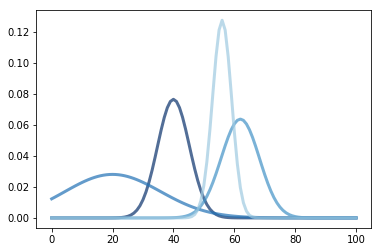

In [161]:
dataset = 'H' * 140 + 'T'*110
for y in [0.2, 0.4, 0.75, 1.0]:
    suite = EuroInstrument(range(0, 101), y)
    for data in dataset:
        suite.Update(data)
    thinkplot.Pdf(suite)

As y increases, the spread of the prior decreases

### Exercise 5###
> Reddit is an online forum with many interest groups called subreddits. Users, called redditors, post links to online content and other web pages. Other redditors vote on the links, giving an “upvote” to high-quality links and a “downvote” to links that are bad or irrelevant.
> 
> A problem, identified by dominosci, is that some redditors are more reliable than others, and Reddit does not take this into account.
> 
> The challenge is to devise a system so that when a redditor casts a vote, the estimated quality of the link is updated in accordance with the reliability of the redditor, and the estimated reliability of the redditor is updated in accordance with the quality of the link.
> 
> One approach is to model the quality of the link as the probability of garnering an upvote, and to model the reliability of the redditor as the probability of correctly giving an upvote to a high-quality item.
> 
> Write class definitions for redditors and links and an update function that updates both objects whenever a redditor casts a vote.